In [1]:
%matplotlib notebook

from matplotlib import pyplot
import numpy
from numpy import random
import wfdb
import pandas
import os
import ipywidgets as widgets
from IPython.display import display, clear_output

import sys
sys.path.append('../libs')
import db, competition

In [2]:
ROOT = '/scr-ssd/mimic/'
RESP_WINDOW_SCALE = 5
WINDOW_SIZE = 500

In [9]:
import tensorflow as tf

In [10]:
tf.config.experimental_list_devices()

['/job:localhost/replica:0/task:0/device:CPU:0',
 '/job:localhost/replica:0/task:0/device:XLA_CPU:0',
 '/job:localhost/replica:0/task:0/device:XLA_GPU:0',
 '/job:localhost/replica:0/task:0/device:XLA_GPU:1',
 '/job:localhost/replica:0/task:0/device:XLA_GPU:2',
 '/job:localhost/replica:0/task:0/device:XLA_GPU:3',
 '/job:localhost/replica:0/task:0/device:XLA_GPU:4',
 '/job:localhost/replica:0/task:0/device:XLA_GPU:5',
 '/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1',
 '/job:localhost/replica:0/task:0/device:GPU:2',
 '/job:localhost/replica:0/task:0/device:GPU:3',
 '/job:localhost/replica:0/task:0/device:GPU:4',
 '/job:localhost/replica:0/task:0/device:GPU:5']

In [7]:
! nvidia-smi

Thu Oct 10 08:24:42 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.78       Driver Version: 410.78       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  On   | 00000000:05:00.0 Off |                  N/A |
| 22%   58C    P2    97W / 250W |  11844MiB / 12212MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX TIT...  On   | 00000000:08:00.0 Off |                  N/A |
| 27%   68C    P2   105W / 250W |  11844MiB / 12212MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
def read_rec(recID, part='train'):
    path = ROOT + part + '/' + str(recID[0]) + '_' + str(recID[1]).zfill(4)
    return db.read_record(path)

In [4]:
def should_flip(wave, sig):
    if sig not in ['I', 'II', 'III', 'V', 'AVR', 'AVF', 'AVL', 'MCL', 'MCL1']:
        return False
    a, b, c = wave.min(), wave.mean(), wave.max()
    return (c - b) < (b - a)

In [5]:
def get_wave(state, rec, sig, index):
    scale = RESP_WINDOW_SCALE if sig == 'RESP' else 1
    window = slice(index - WINDOW_SIZE * scale, index, scale)
    wave = rec.p_signal[window, rec.sig_name.index(sig)]
    if should_flip(wave, sig): wave *= -1
    return wave

In [6]:
def get_view_limits(wave):
    ys = wave[~numpy.isnan(wave)]
    low, high = ys.min(), ys.max()
    dy = high - low
    limits = {}
    limits['bottom'] = low - 0.1 * dy - 1e-9
    limits['top'] = high + 0.1 * dy + 1e-9
    return limits

In [7]:
def set_label(state, sig, label):
    state['current_labels'][sig] = label
    state['lines'][sig].set_color('darkblue' if label else 'red')
    state['axes'][sig].yaxis.label.set_color('black' if label else 'darkred')
    state['boxes'][sig].set_state({'value': label})
    state['boxes'][sig].send_state()

In [8]:
def add_subplot(state, sig, rec, index):
    wave = get_wave(state, rec, sig, index)
    S = state['current_sigs']
    label = '_'.join([sig, rec.record_name, str(index)])
    state['axes'][sig] = pyplot.subplot(len(S), 1, S.index(sig) + 1, label=label)
    state['axes'][sig].yaxis.tick_right()
    state['axes'][sig].set_ylabel(sig)
    state['lines'][sig] = state['axes'][sig].plot(wave, 'darkblue')[0]
    state['axes'][sig].set_ylim(**get_view_limits(wave))

In [9]:
def handle_box(state, sig):
    def _handle_box(change):
        if change['name'] == 'value':
            set_label(state, sig, change['new'])
            state['fig'].canvas.draw()
    return _handle_box

In [10]:
def deselect_all(state):
    def _deselect_all(b):
        for sig in state['current_sigs']:
            set_label(state, sig, False)
        state['fig'].canvas.draw()
        widgets.VBox(list(state['boxes'].values()))
    return _deselect_all

In [11]:
def save_labels(state):
    def _save_labels(b):
        if 'record_id' in state['current_labels']:
            state['labels'].append(state['current_labels'].copy())
        labels = pandas.DataFrame(state['labels'])
        if os.path.isfile(state['labels_file']):
            old_labels = pandas.read_csv(state['labels_file'])
            labels = pandas.concat([old_labels, labels], join='outer', sort=True)
        labels.set_index(['record_id', 'segment', 'index']).to_csv(state['labels_file'])
        state['labels'].clear()
        state['current_labels'].clear()
        next_window(state)(None)
    return _save_labels

In [19]:
def next_window(state):
    p = state['metadata']['sig_len'] / state['metadata']['sig_len'].sum()
    def _next_window(b):
        if 'record_id' in state['current_labels']:
            state['labels'].append(state['current_labels'].copy())
        recID = random.choice(state['metadata'].index, p=p.values)
        
        print("recID",recID)
        rec = read_rec(recID)
        index = random.randint(WINDOW_SIZE * RESP_WINDOW_SCALE, rec.sig_len)
        state['current_labels'] = {'record_id': recID[0], 'segment': recID[1], 'index': index}
        state['axes'], state['boxes'], state['lines'] = {}, {}, {}
        state['current_sigs'] = [sig for sig in state['sigs'] if sig in rec.sig_name]
        
        for sig in state['current_sigs']:
            state['current_labels'][sig] = True
            add_subplot(state, sig, rec, index)
            state['boxes'][sig] = widgets.Checkbox(
                value=True, 
                description=sig, 
                indent=False, 
                layout=widgets.Layout(width='100px', height='40px')
            )
            state['boxes'][sig].observe(handle_box(state, sig))
        
        clear_output(wait=True)
        state['fig'].set_figheight(min(5, len(state['current_sigs'])))
        state['fig'].set_figwidth(6)
        display(state['fig'])
        state['fig'].canvas.draw()
        B = list(state['boxes'].values())
        i = (len(B) + 1) // 2
        display(widgets.HBox([
            widgets.VBox(B[:i]), 
            widgets.VBox(B[i:]), 
            widgets.VBox(state['buttons'])
        ]))
    return _next_window

In [13]:
def init_state(metadata, sigs, labels_file='clean_labels.csv'):
    
    state = {
        'metadata': metadata, 
        'sigs': sigs,
        'labels_file': labels_file
    }
    
    state['labels'], state['current_labels'] = [], {}
    state['fig'] = pyplot.figure(1)
    pyplot.subplots_adjust(wspace=0, hspace=0)

    vspace = {'layout': widgets.Layout(margin='0 0 10px 0')}

    deselect_all_button = widgets.Button(description='Deselect All', **vspace)
    deselect_all_button.on_click(deselect_all(state))
    
    save_button = widgets.Button(description='Next and Save')
    save_button.on_click(save_labels(state))

    summary_table = widgets.Output()
    
    state['buttons'] = [deselect_all_button, save_button]
    
    next_window(state)(None)
    
    return state

In [18]:
ecg_sigs = ['I', 'II', 'III', 'V', 'AVR', 'AVF', 'AVL', 'MCL', 'MCL1']
pressure_sigs = ['ABP', 'ART', 'CVP', 'PAP', 'ICP']
other_sigs = ['PLETH', 'RESP']
sigs = ecg_sigs + other_sigs + pressure_sigs
metadata = pandas.read_csv('/scr-ssd/mimic/metadata.csv')
metadata['sig_name'] = metadata['sig_name'].apply(lambda i: eval(i), convert_dtype=True)
metadata.set_index(['record_id', 'segment'], verify_integrity=True, inplace=True)
recIDs = os.listdir(ROOT + 'train')
recIDs = [i.split('.')[0].split('_') for i in recIDs if '_x.flac' in i]
recIDs = [(int(i[0]), int(i[1])) for i in recIDs]
recIDs = sorted(set(recIDs).intersection(metadata.index))
metadata = metadata.loc[recIDs]
metadata = metadata[metadata['sig_len'].between(125 * 60, 125 * 60 * 60 * 5)]
metadata = metadata[metadata['sig_name'].apply(lambda i: any(j in i for j in sigs))]
len(metadata)

66767

<IPython.core.display.Javascript object>


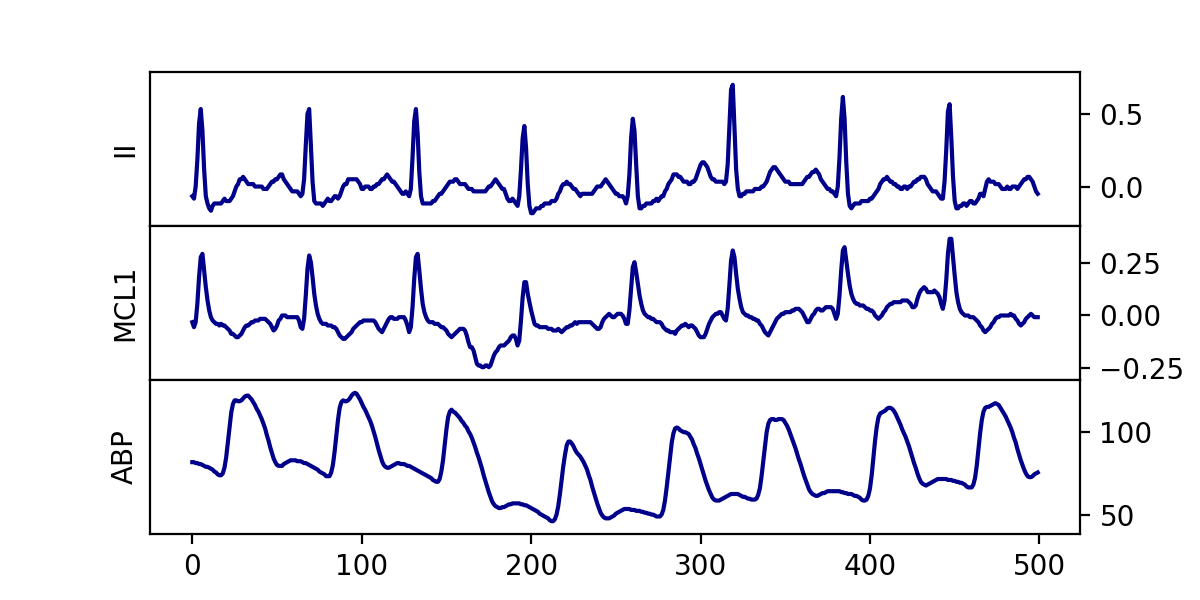

In [20]:
state = labeler.init(metadata, sigs)

In [16]:
pandas.read_csv('clean_labels.csv')

,record_id,segment,index,ABP,ART,AVF,AVL,AVR,CVP,I,ICP,II,III,MCL,MCL1,PAP,PLETH,RESP,V
0,3636722,12,1262622,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,True,True,True
1,3676776,18,167341,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,True,True,True
2,3311928,92,49376,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,True,True,True
3,3334855,13,75142,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,True,False,True
4,3933563,12,1060843,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,True,False,True
5,3327980,4,225142,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,True,False,True
6,3551072,7,1241173,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,True,False,True
7,3365548,34,452174,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,True,True,True
8,3434032,257,125649,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,True,True,True
9,3270010,50,628256,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,True,False,True
